# Flag detection analysis

The purpose of this jupyter notebook is to:
* visualize data which the following flags are based on: _hovering, cloud, pollution_;
* visualize available manually created flags;
* based on the manually created flags, find the best parameters for the flag detection algorithm to later use those parameters for the automatic creation of flags.

In [1]:
%load_ext autoreload
%autoreload 2

## Load data

In [2]:
from helikite.constants import constants

# specify the directories containing the data
level1_5_dir_relpaths = [
    "ORACLES/Helikite/2024-2025/Data/Processed/Level1.5",
    "Turtmann/data/Helikite/Processing/Level1.5",
]
level1_5_dir_abspaths = [constants.DATA_DIRPATH / relpath for relpath in level1_5_dir_relpaths]

# specify the data columns and the corresponding flag columns
columns_to_flags = {
    "Altitude": "flag_hovering",
    "mCDA_total_N": "flag_cloud",
    "CPC_total_N": "flag_pollution",
}

In [3]:
import os
import pandas as pd
import re

# load all data into a single dataframe
dfs = []
all_columns = list(columns_to_flags.keys()) + list(columns_to_flags.values())

# change the regex pattern if other file naming conventions were used
pattern = re.compile(r".*_[A-Z]\.csv")

for dirpath in level1_5_dir_abspaths:
    for filename in os.listdir(dirpath):
        if not filename.endswith(".csv") or pattern.search(filename) is None:
            continue

        filepath = dirpath / filename

        dtype = {c: "Float64" for c in columns_to_flags.keys()} | {c: "boolean" for c in columns_to_flags.values()}
        try:
            df = pd.read_csv(filepath, index_col="datetime", parse_dates=["datetime"], dtype=dtype)
        except Exception as e:
            print(f"Error in processing {filepath}: {e}")
            continue
        freq = pd.infer_freq(df.index)

        for col in all_columns:
            if col not in df.columns:
                df[col] = pd.Series(dtype=dtype[col])

        dfs.append(df[all_columns])

df = pd.concat(dfs)
df.sort_index(inplace=True)
df = df[~df.index.duplicated(keep="first")]

/tmp/ipykernel_270811/2513389615.py:21: DtypeWarning: Columns (344,346,348,351,356,361) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, index_col="datetime", parse_dates=["datetime"], dtype=dtype)


In [4]:
from helikite.processing.post.fda import FDA, FDAParameters

## Plot data
### Plot 2D histogram and time series
There are two 2D histograms in the plots (a):
1) _blue:_ all observations;
2) _light yellow:_ observations with a manual flag equal to 1.

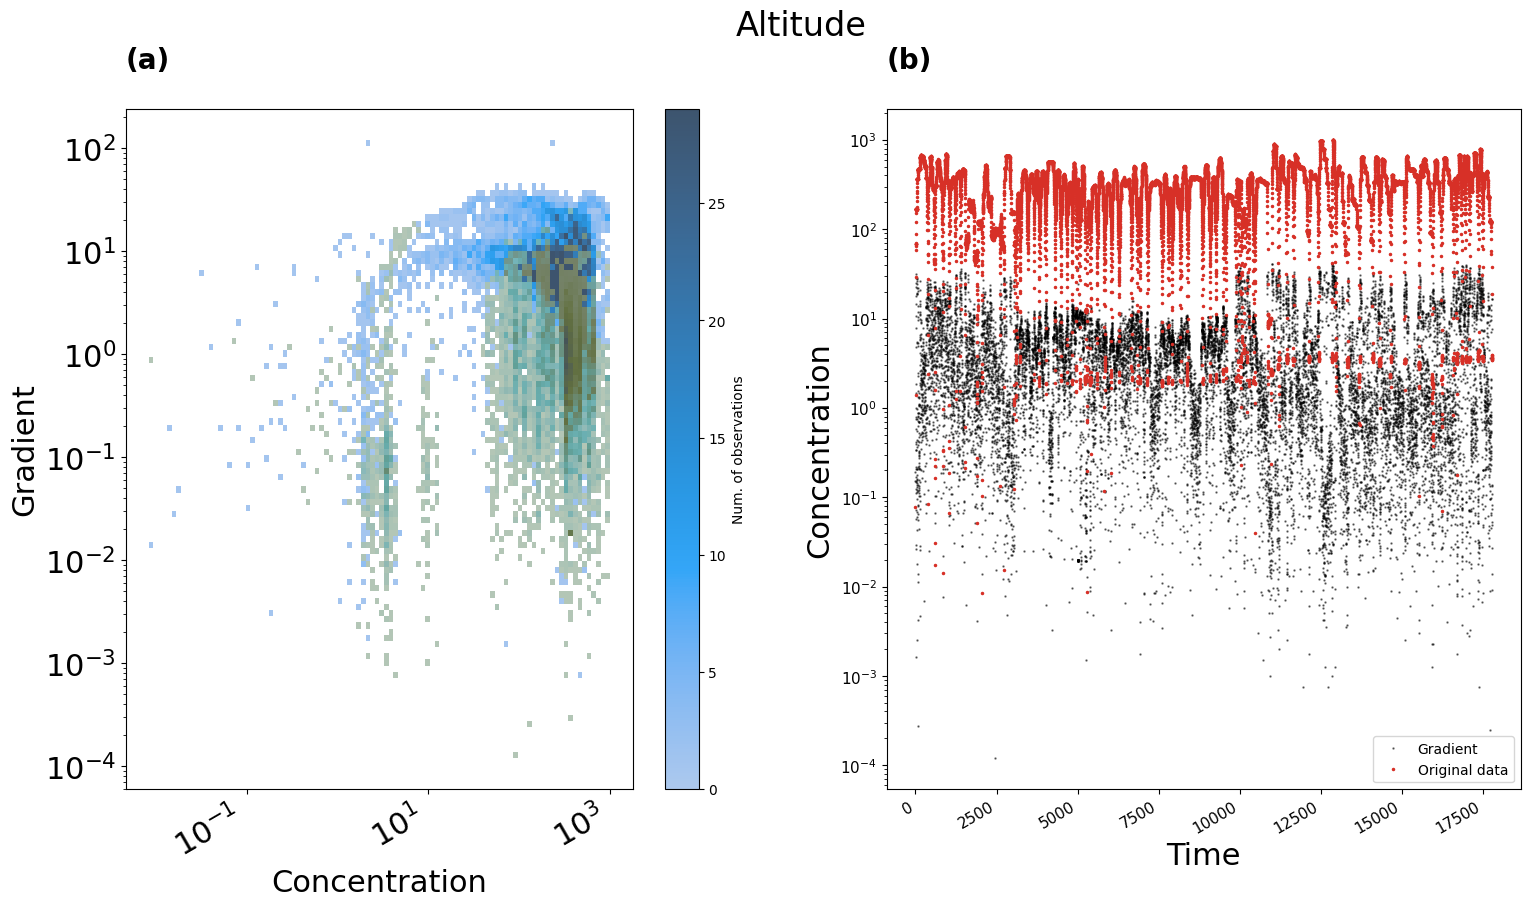

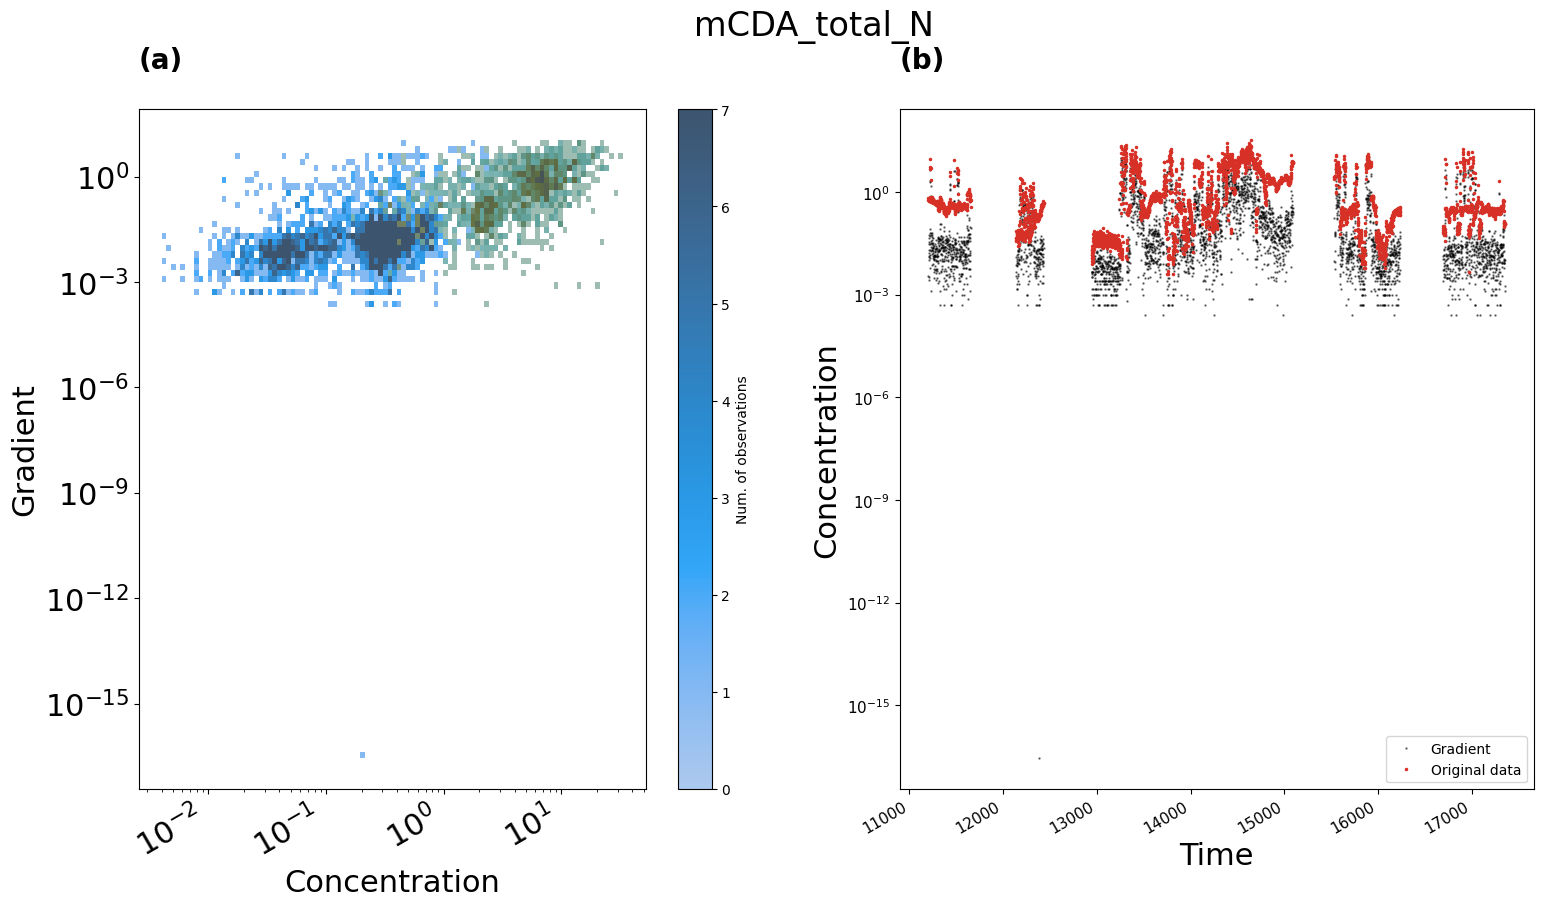

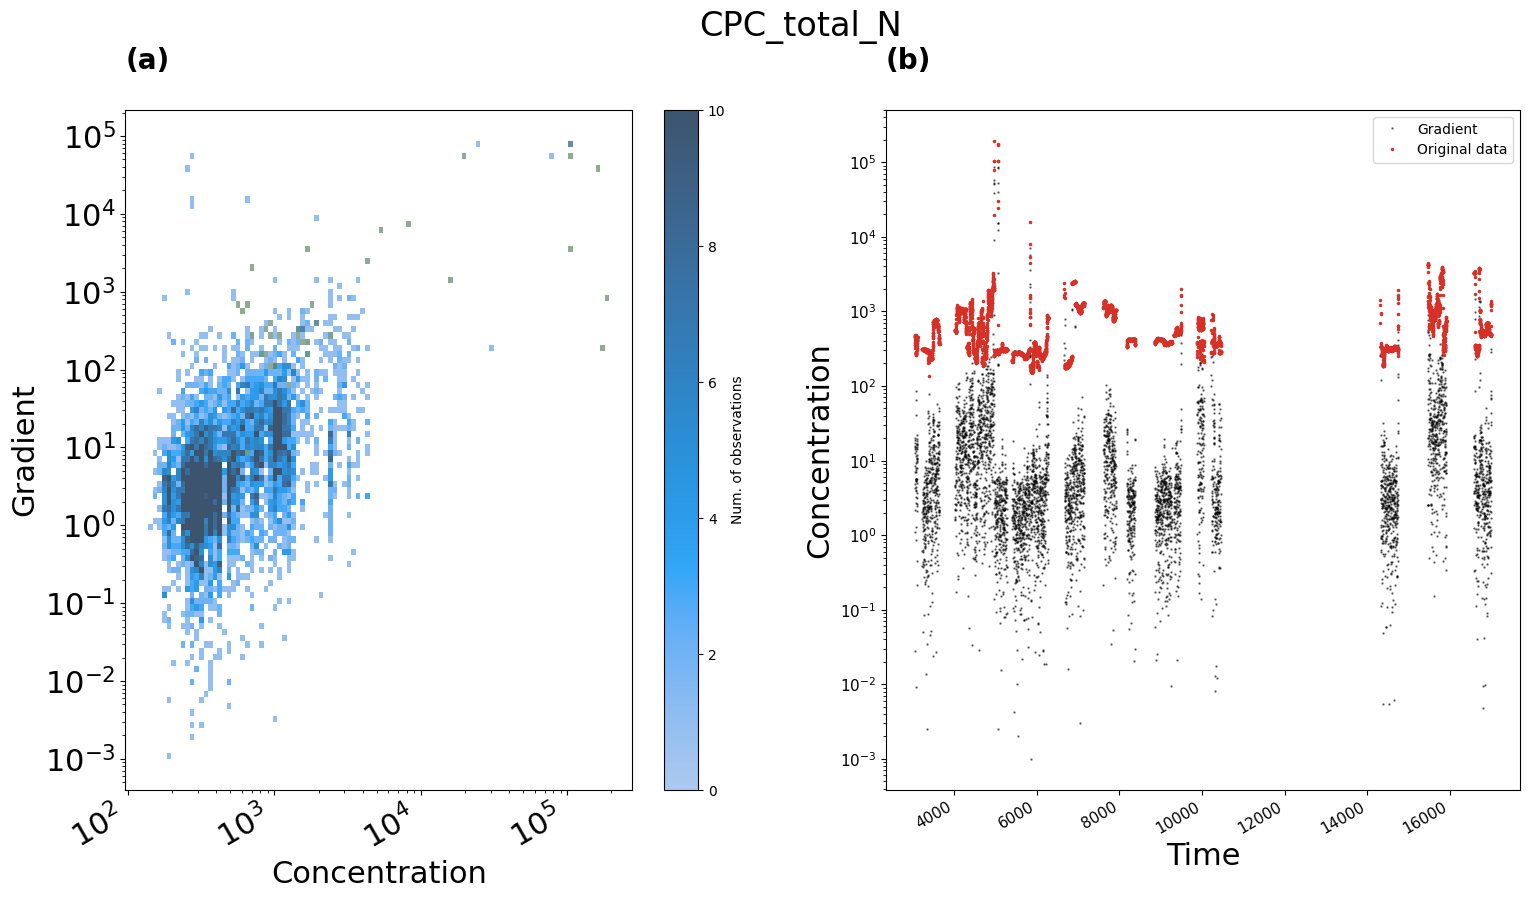

In [5]:
for col, flag_col in columns_to_flags.items():
    fda = FDA(df, col, flag_col, FDAParameters(inverse=flag_col == "flag_hovering", avg_time="20s"))
    fda.plot_data(use_time_index=False)

### Plot 2D histogram and time series with thresholds

Try defining thresholds and see them on the histogram plots.
In 2D histogram, observations in the areas shaded with red color:
* _vertical:_ will be filtered out by the main filter;
* _horizontal:_ will be filtered out by the main filter in case `power_law` main filter is used;

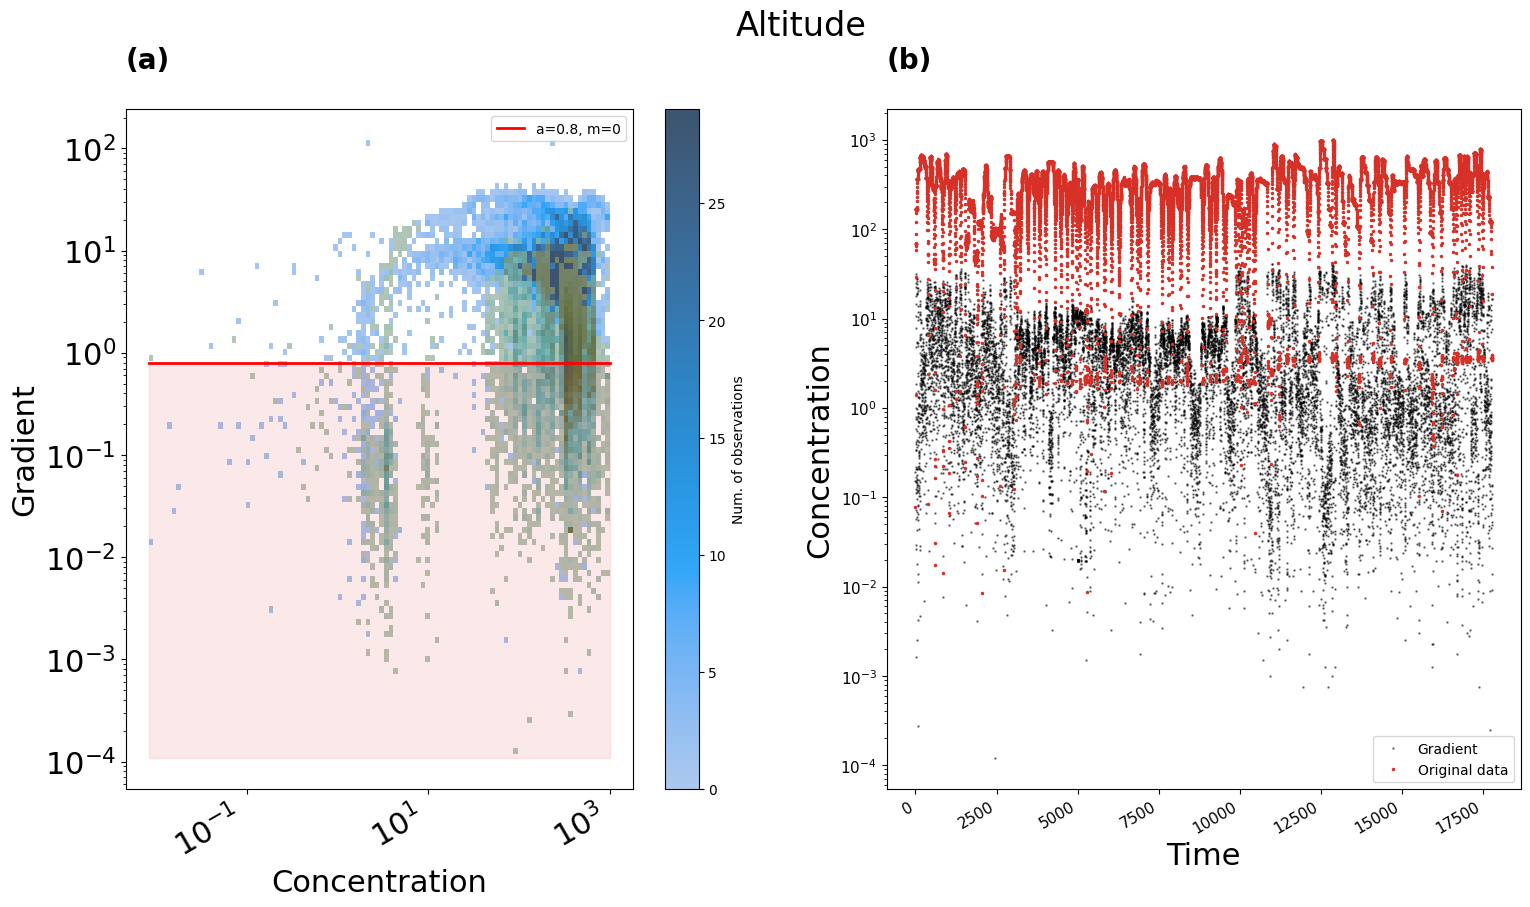

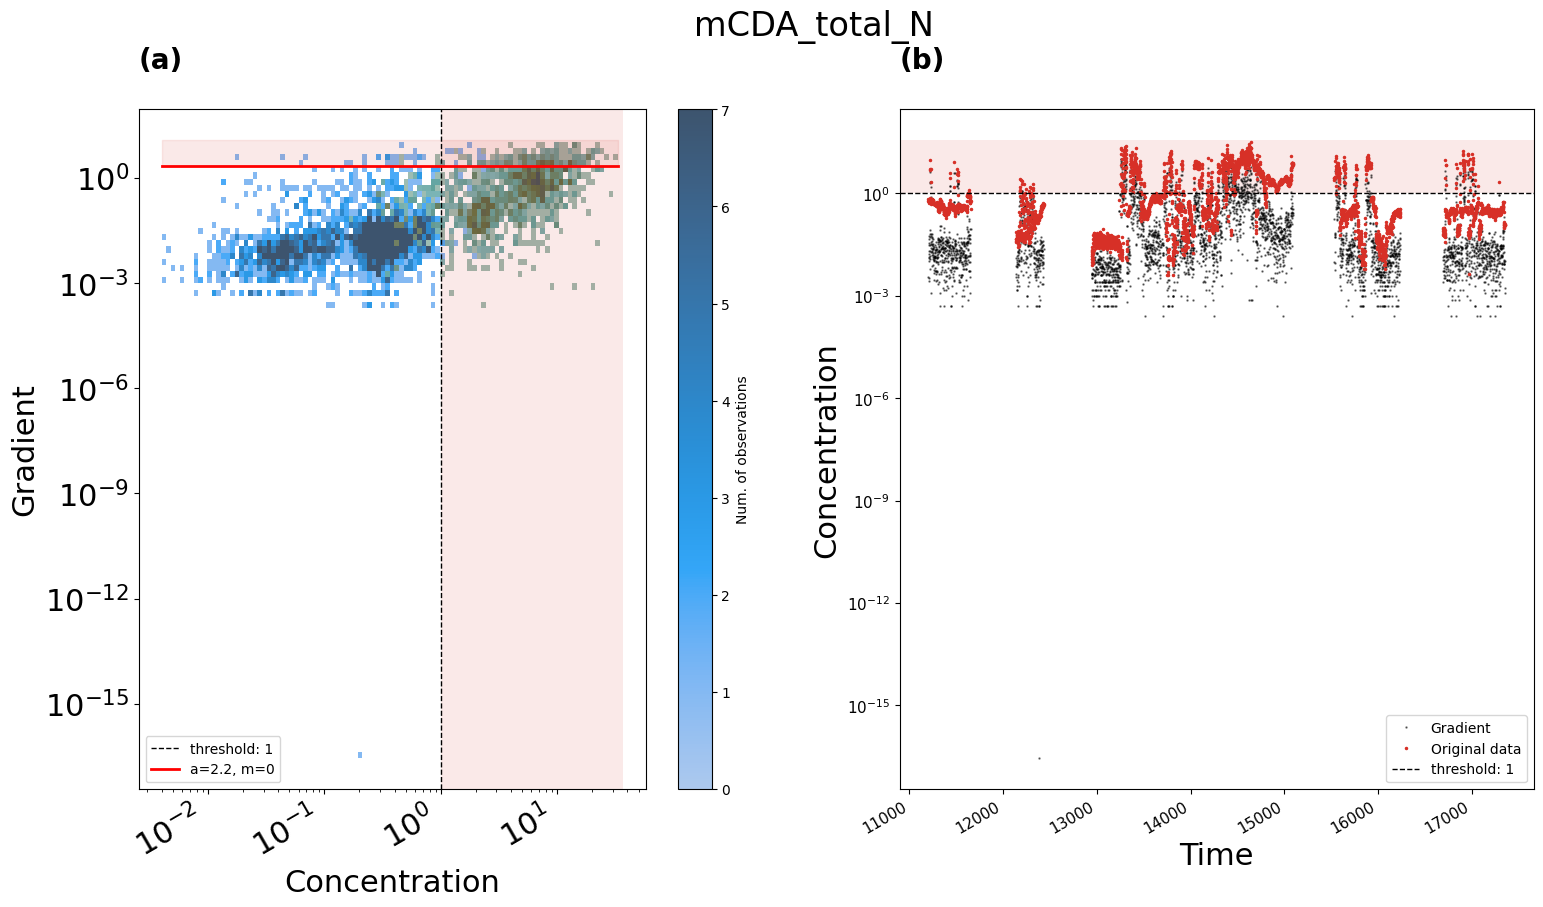

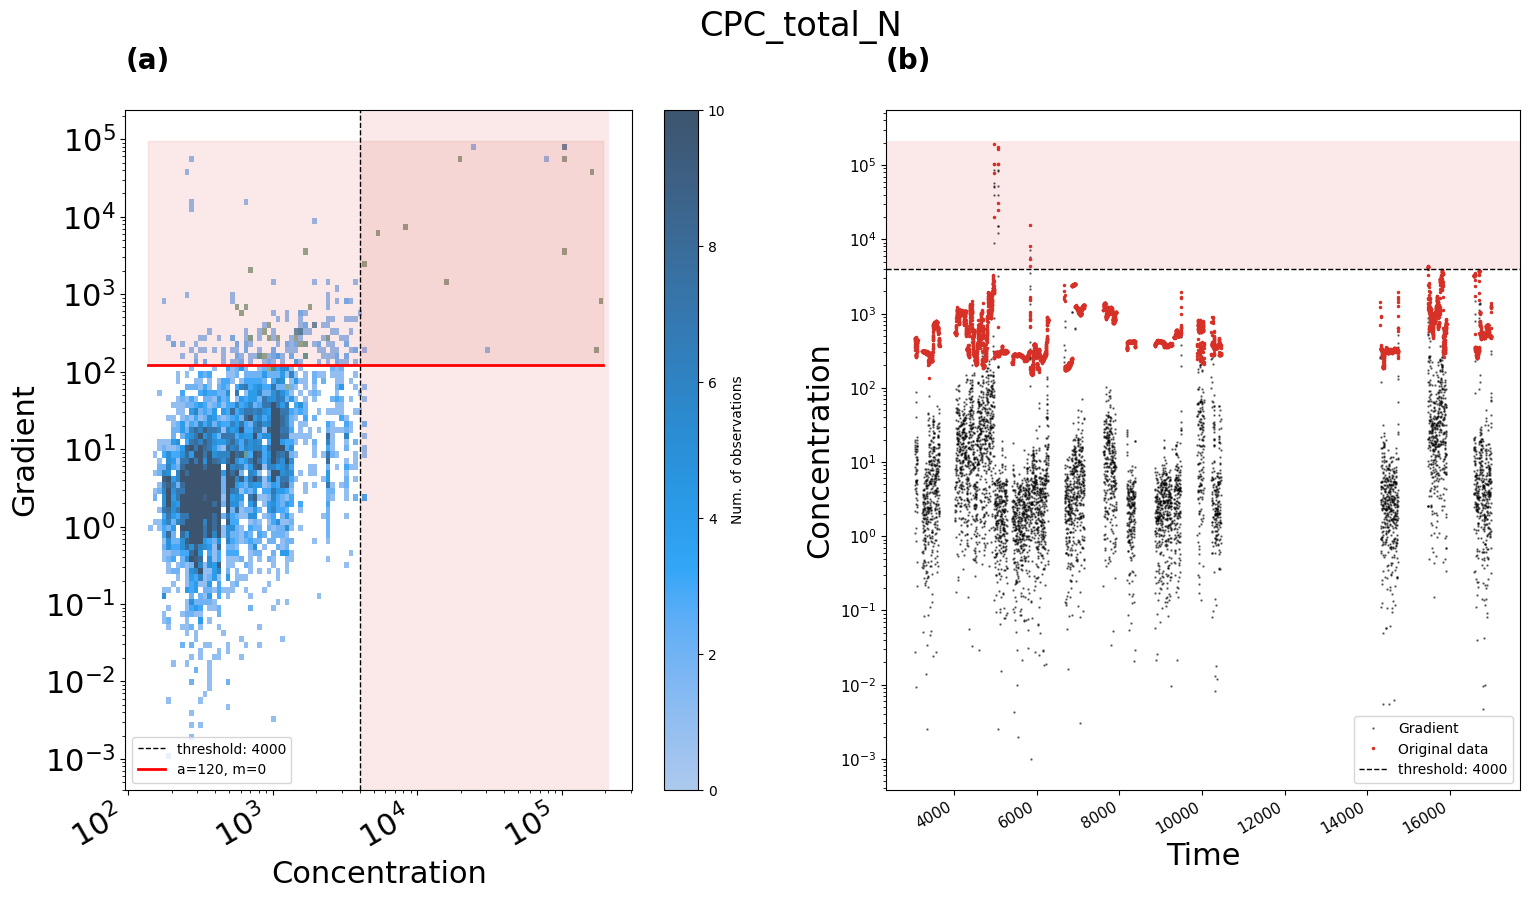

In [6]:
import numpy as np

params = {
    "Altitude": FDAParameters(
        inverse=True,
        avg_time="20s",
        lower_thr=-np.inf,
        pl_a=0.8,
        pl_m=0,
    ),
    "mCDA_total_N": FDAParameters(
        inverse=False,
        avg_time="20s",
        lower_thr=0,
        upper_thr=1,
        pl_a=2.2,
        pl_m=0,
    ),
    "CPC_total_N": FDAParameters(
        inverse=False,
        avg_time="20s",
        lower_thr=0,
        upper_thr=4000,
        pl_a=120,
        pl_m=0,
    ),
}

for col, flag_col in columns_to_flags.items():
    fda = FDA(df, col, flag_col, params[col])
    fda.plot_data(use_time_index=False)

## Find the best parameters using grid search
In the following cells, define the values of the paramaters to try.
The best parameters will be chosen using grid search.
See documentation for `helikite.processing.post.fda.FDA` to better understand what each parameter does.

In [7]:
import itertools
import dataclasses

def find_best_params(df: pd.DataFrame, column: str, flag_column: str, base_params: FDAParameters, grid: dict[str, list[float]]):
    assert (~df[flag_column].isna()).any(), f"No ground truth (manually specified) values for {flag_column} available"

    best_f1 = 0
    best_params = None

    for values in itertools.product(*grid.values()):
        params = dataclasses.replace(base_params, **dict(zip(grid.keys(), values)))

        fda = FDA(df, column, flag_column, params)
        flag = fda.detect_pollution()

        f1 = FDA.evaluate(df[column], flag, df[flag_column], verbose=False)

        if f1 > best_f1:
            best_f1 = f1
            best_params = params

    print(f"Best params with f1 score {best_f1}: {best_params}")

    fda = FDA(df, column, flag_column, best_params)
    flag = fda.detect_pollution()
    _ = FDA.evaluate(df[column], flag, df[flag_column], verbose=True)

    return best_params, best_f1

The same parameter grid is used for secondary filters, i.e. neighbor, median, and sparse filters.
Try changing the parameter grid in the cell below, or directly specify secondary filter parameters in the cells that follow, where for each flag grid search is launched.

In [8]:
import numpy as np

best_params = {}

grid_secondary_filters = {
    "use_neighbor_filter": [True, False],
    "use_median_filter": [True],
    "use_sparse_filter": [True],
    "median_window": ["1min", "2min"],
    "median_factor": [2.0, 4.0, np.inf],
    "sparse_window": [30],
    "sparse_thr": [26, 28, 30],
}

In [9]:
# specify main filter parameters for hovering detection
column = "Altitude"
flag_column = columns_to_flags[column]

base_params = FDAParameters(
    inverse=True,
    avg_time="10s",
)

grid_iqr = {
    "main_filter": ["iqr"],
    "iqr_window": ["32min", "64min", "128min"],
    "iqr_factor": [-1.6, -0.8, -0.4],
}

grid_pl = {
    "main_filter": ["power_law"],
    "pl_a": [0.4, 0.8, 1.0],
}

best_params_iqr, f1_iqr = find_best_params(df, column, flag_column, base_params, grid_secondary_filters | grid_iqr)
best_params_pl, f1_pl = find_best_params(df, column, flag_column, base_params, grid_secondary_filters | grid_pl)

best_params[column] = best_params_pl if f1_iqr < f1_pl else best_params_iqr

Best params with f1 score 0.7050316615757604: FDAParameters(inverse=True, avg_time='10s', main_filter='iqr', use_neighbor_filter=True, use_median_filter=True, use_sparse_filter=True, pl_a=inf, pl_m=0, iqr_window='128min', iqr_factor=-0.8, lower_thr=-inf, upper_thr=inf, median_window='1min', median_factor=4.0, sparse_window=30, sparse_thr=26)
TP = 124755
FP = 84827
TN = 124906
FN = 19562
Precision = 0.5952562720080923
Recall = 0.8644511734584284
F1 = 0.7050316615757604
Best params with f1 score 0.7800607202874466: FDAParameters(inverse=True, avg_time='10s', main_filter='power_law', use_neighbor_filter=True, use_median_filter=True, use_sparse_filter=True, pl_a=0.8, pl_m=0, iqr_window=None, iqr_factor=None, lower_thr=-inf, upper_thr=inf, median_window='1min', median_factor=4.0, sparse_window=30, sparse_thr=28)
TP = 126027
FP = 52777
TN = 156947
FN = 18290
Precision = 0.7048332252074898
Recall = 0.8732651039032131
F1 = 0.7800607202874466


In [10]:
# specify main filter parameters for cloud detection
column = "mCDA_total_N"
flag_column = columns_to_flags[column]

base_params = FDAParameters(
    inverse=False,
    avg_time="1s",
)

grid_iqr = {
    "main_filter": ["iqr"],
    "upper_thr": [0.8, 1, 1.2],
    "iqr_window": ["32min", "64min", "128min"],
    "iqr_factor": [-0.4, -0.2, 0.0, 0.2],
}

grid_pl = {
    "main_filter": ["power_law"],
    "upper_thr": [0.8, 1, 1.2],
    "pl_a": [1.8, 2.0, 2.2],
}

best_params_iqr, f1_iqr = find_best_params(df, column, flag_column, base_params, grid_secondary_filters | grid_iqr)
best_params_pl, f1_pl = find_best_params(df, column, flag_column, base_params, grid_secondary_filters | grid_pl)

best_params[column] = best_params_pl if f1_iqr < f1_pl else best_params_iqr

Best params with f1 score 0.8539251077138056: FDAParameters(inverse=False, avg_time='1s', main_filter='iqr', use_neighbor_filter=False, use_median_filter=True, use_sparse_filter=True, pl_a=inf, pl_m=0, iqr_window='128min', iqr_factor=0.2, lower_thr=-inf, upper_thr=1, median_window='1min', median_factor=inf, sparse_window=30, sparse_thr=26)
TP = 25666
FP = 7857
TN = 49017
FN = 924
Precision = 0.7656236017062912
Recall = 0.9652500940203084
F1 = 0.8539251077138056
Best params with f1 score 0.9499145623694704: FDAParameters(inverse=False, avg_time='1s', main_filter='power_law', use_neighbor_filter=True, use_median_filter=True, use_sparse_filter=True, pl_a=1.8, pl_m=0, iqr_window=None, iqr_factor=None, lower_thr=-inf, upper_thr=1.2, median_window='1min', median_factor=inf, sparse_window=30, sparse_thr=26)
TP = 25016
FP = 1065
TN = 55795
FN = 1573
Precision = 0.9591656761627239
Recall = 0.9408401970739779
F1 = 0.9499145623694704


In [11]:
# specify main filter parameters for pollution detection
column = "CPC_total_N"
flag_column = columns_to_flags[column]

base_params = FDAParameters(
    inverse=False,
    avg_time="1s",
)

grid_iqr = {
    "main_filter": ["iqr"],
    "upper_thr": [0.6, 0.8, 1],
    "iqr_window": ["1min", "4min", "16min", "64min"],
    "iqr_factor": [-3.2 -1.6, -0.8],
}

grid_pl = {
    "main_filter": ["power_law"],
    "upper_thr": [2000, 3000, 4000],
    "pl_a": [30, 60, 120]
}

best_params_iqr, f1_iqr = find_best_params(df, column, flag_column, base_params, grid_secondary_filters | grid_iqr)
best_params_pl, f1_pl = find_best_params(df, column, flag_column, base_params, grid_secondary_filters | grid_pl)

best_params[column] = best_params_pl if f1_iqr < f1_pl else best_params_iqr

Best params with f1 score 0.01786839121488263: FDAParameters(inverse=False, avg_time='1s', main_filter='iqr', use_neighbor_filter=True, use_median_filter=True, use_sparse_filter=True, pl_a=inf, pl_m=0, iqr_window='1min', iqr_factor=-4.800000000000001, lower_thr=-inf, upper_thr=0.6, median_window='1min', median_factor=2.0, sparse_window=30, sparse_thr=26)
TP = 851
FP = 93550
TN = 0
FN = 0
Precision = 0.009014735013400282
Recall = 1.0
F1 = 0.01786839121488263
Best params with f1 score 0.6177260519247986: FDAParameters(inverse=False, avg_time='1s', main_filter='power_law', use_neighbor_filter=True, use_median_filter=True, use_sparse_filter=True, pl_a=120, pl_m=0, iqr_window=None, iqr_factor=None, lower_thr=-inf, upper_thr=4000, median_window='1min', median_factor=2.0, sparse_window=30, sparse_thr=26)
TP = 690
FP = 695
TN = 92825
FN = 159
Precision = 0.4981949458483754
Recall = 0.8127208480565371
F1 = 0.6177260519247986


## Plot detection results with the best parameters
After grid search was launched, and for every type of data the best parameters were saved, plot detection results for the parameters found.

In [12]:
for col, ps in best_params.items():
    if ps.use_median_filter and not np.isfinite(ps.median_factor):
        ps.use_median_filter = False
    if ps.use_sparse_filter and ps.sparse_window == ps.sparse_thr:
        ps.use_sparse_filter = False

fda parameters used for Altitude:
{'inverse': True,
 'avg_time': '10s',
 'main_filter': 'power_law',
 'use_neighbor_filter': True,
 'use_median_filter': True,
 'use_sparse_filter': True,
 'pl_a': 0.8,
 'pl_m': 0,
 'iqr_window': None,
 'iqr_factor': None,
 'lower_thr': -inf,
 'upper_thr': inf,
 'median_window': '1min',
 'median_factor': 4.0,
 'sparse_window': 30,
 'sparse_thr': 28}
TP = 126027
FP = 52777
TN = 156947
FN = 18290
Precision = 0.7048332252074898
Recall = 0.8732651039032131
F1 = 0.7800607202874466


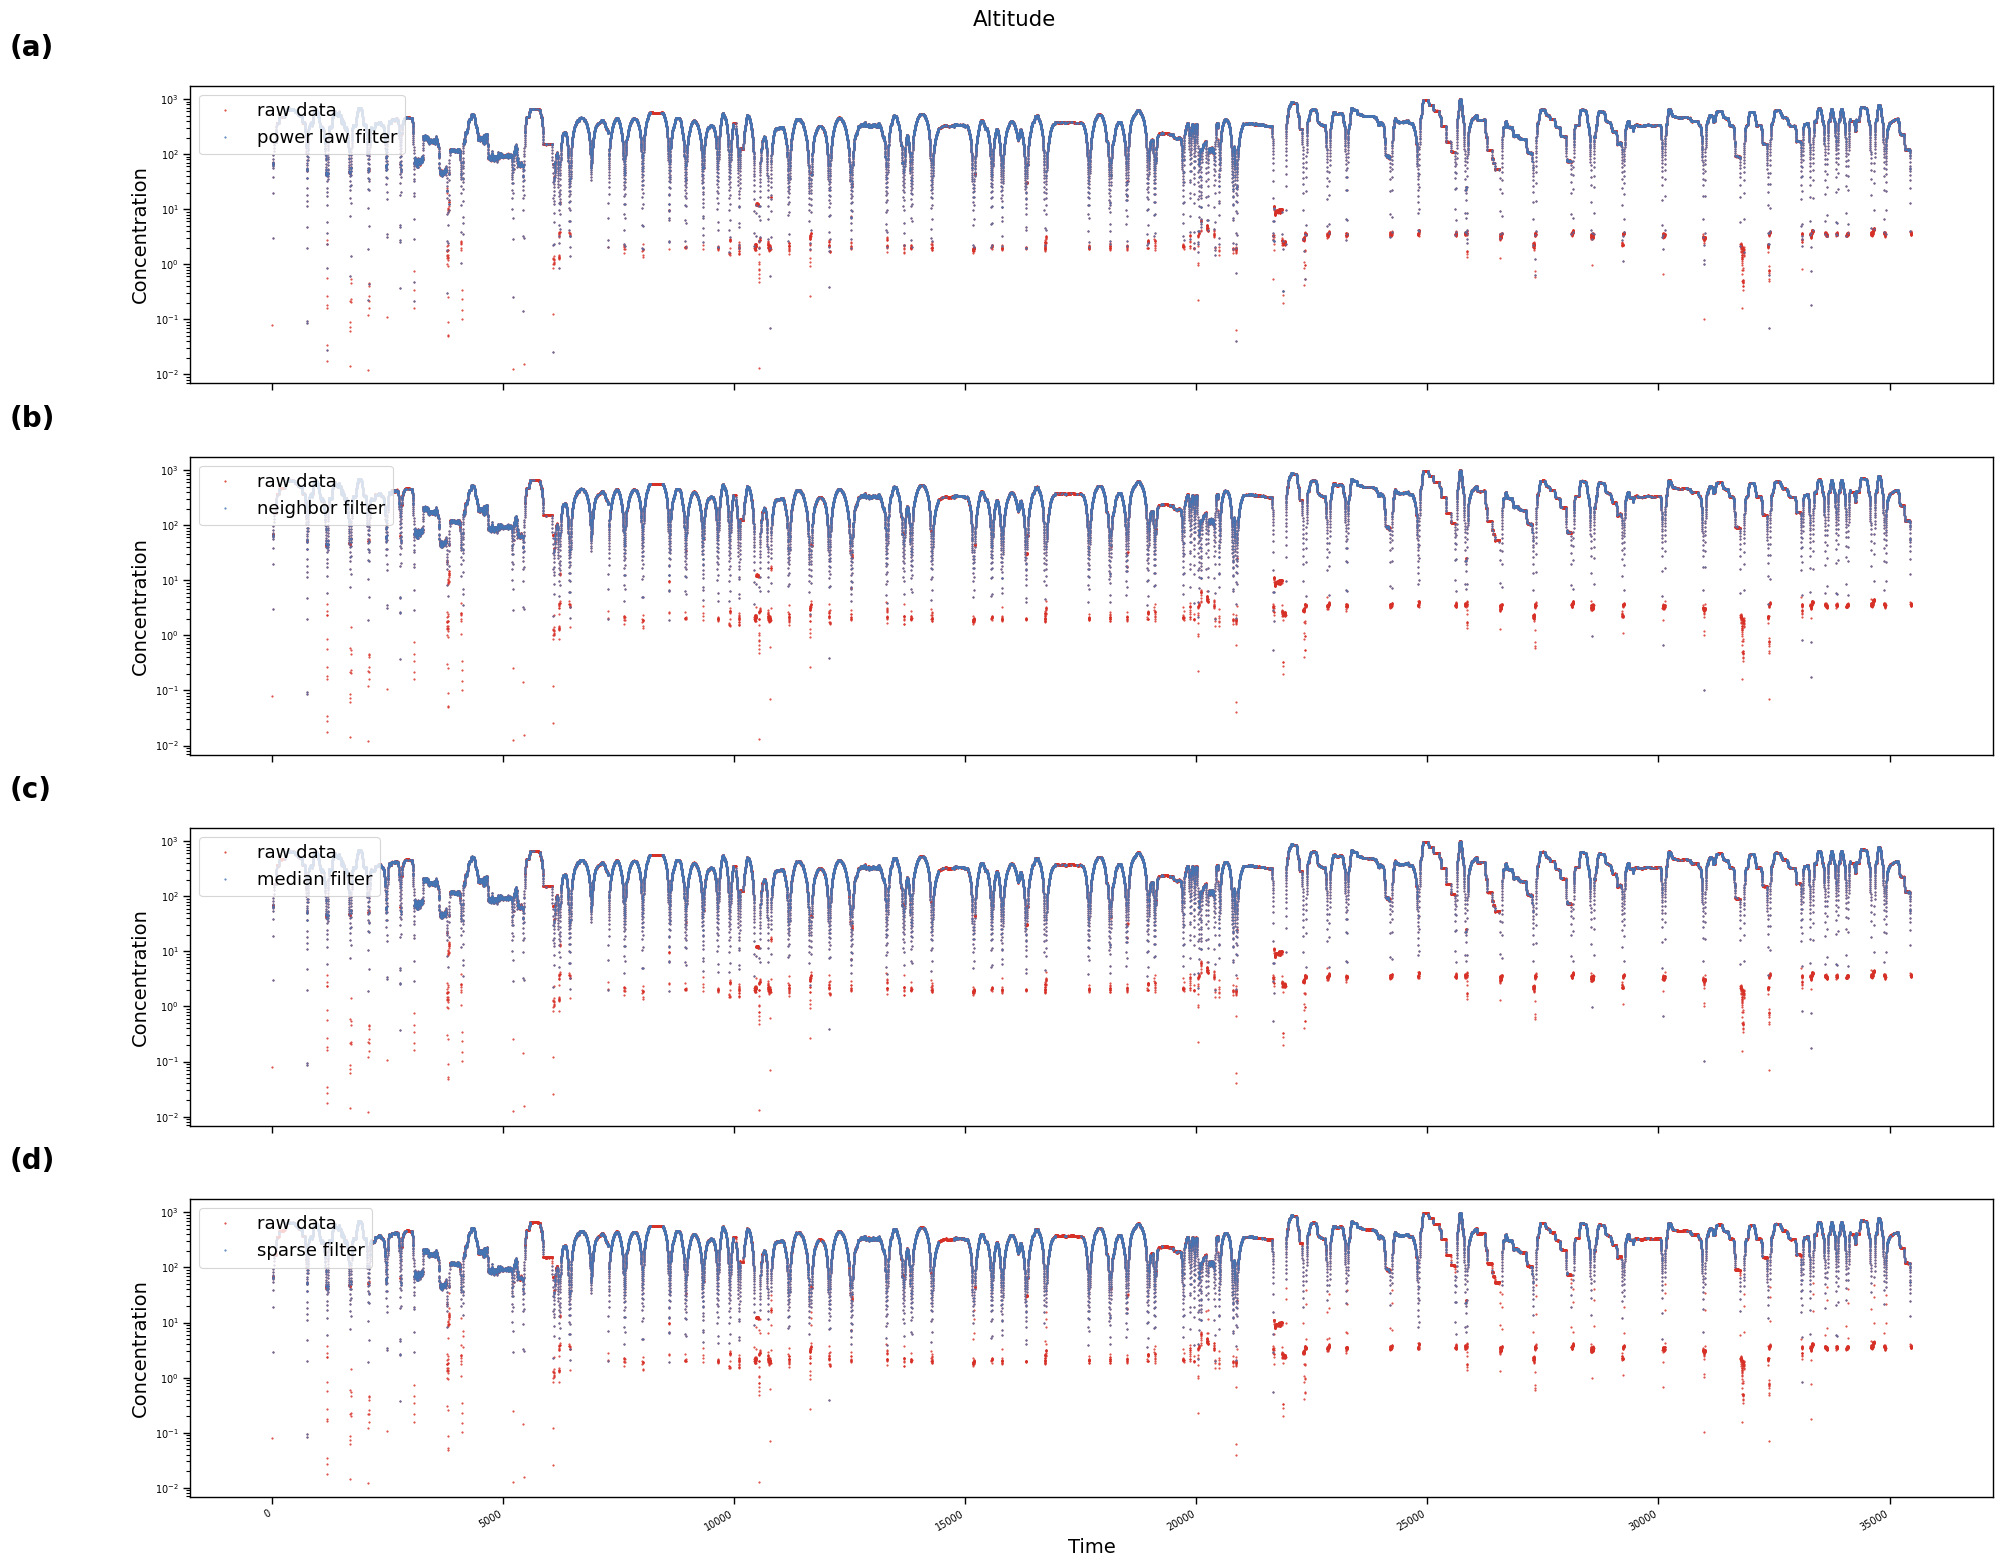

fda parameters used for mCDA_total_N:
{'inverse': False,
 'avg_time': '1s',
 'main_filter': 'power_law',
 'use_neighbor_filter': True,
 'use_median_filter': False,
 'use_sparse_filter': True,
 'pl_a': 1.8,
 'pl_m': 0,
 'iqr_window': None,
 'iqr_factor': None,
 'lower_thr': -inf,
 'upper_thr': 1.2,
 'median_window': '1min',
 'median_factor': inf,
 'sparse_window': 30,
 'sparse_thr': 26}
TP = 25016
FP = 1065
TN = 56913
FN = 1573
Precision = 0.9591656761627239
Recall = 0.9408401970739779
F1 = 0.9499145623694704


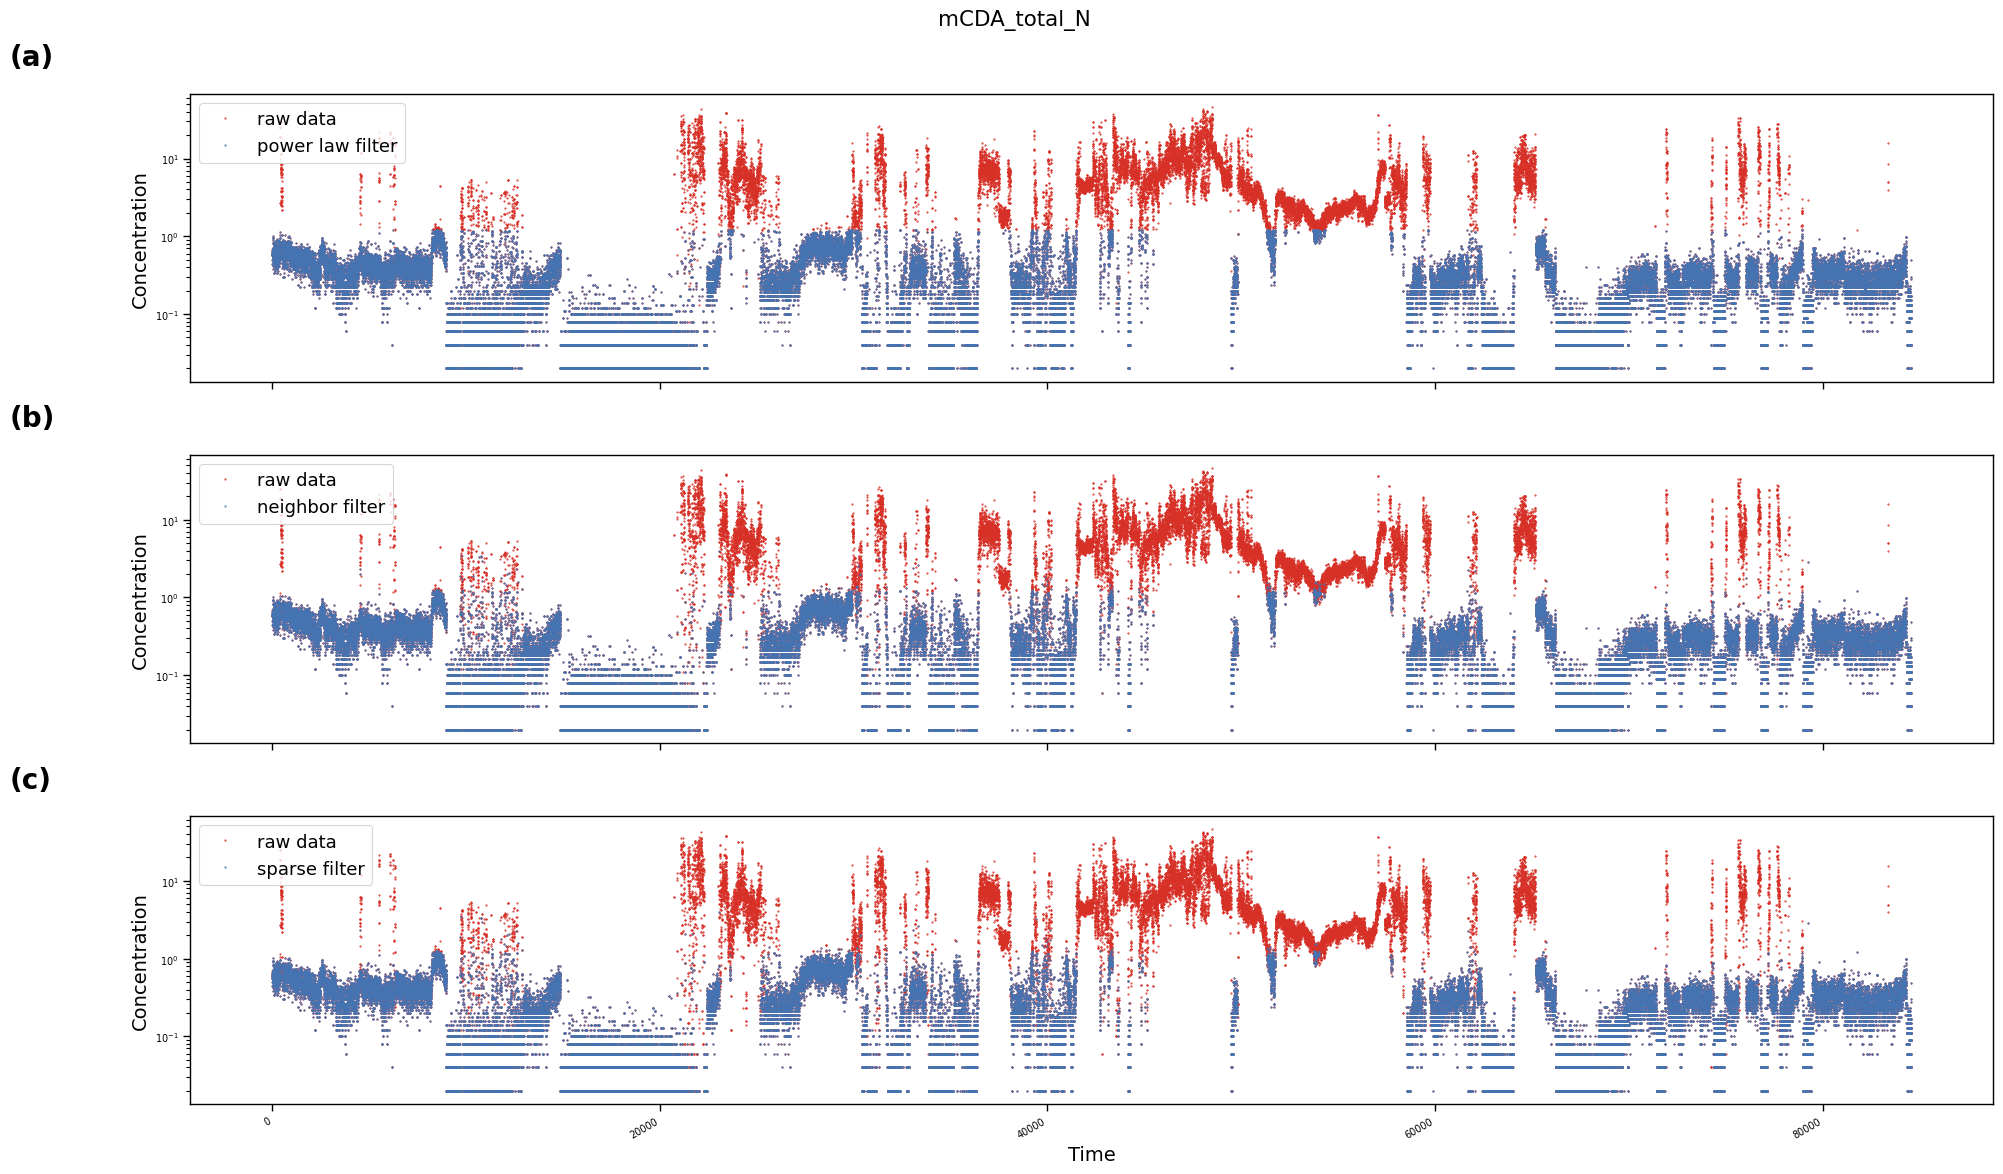

fda parameters used for CPC_total_N:
{'inverse': False,
 'avg_time': '1s',
 'main_filter': 'power_law',
 'use_neighbor_filter': True,
 'use_median_filter': True,
 'use_sparse_filter': True,
 'pl_a': 120,
 'pl_m': 0,
 'iqr_window': None,
 'iqr_factor': None,
 'lower_thr': -inf,
 'upper_thr': 4000,
 'median_window': '1min',
 'median_factor': 2.0,
 'sparse_window': 30,
 'sparse_thr': 26}
TP = 690
FP = 695
TN = 92825
FN = 159
Precision = 0.4981949458483754
Recall = 0.8127208480565371
F1 = 0.6177260519247986


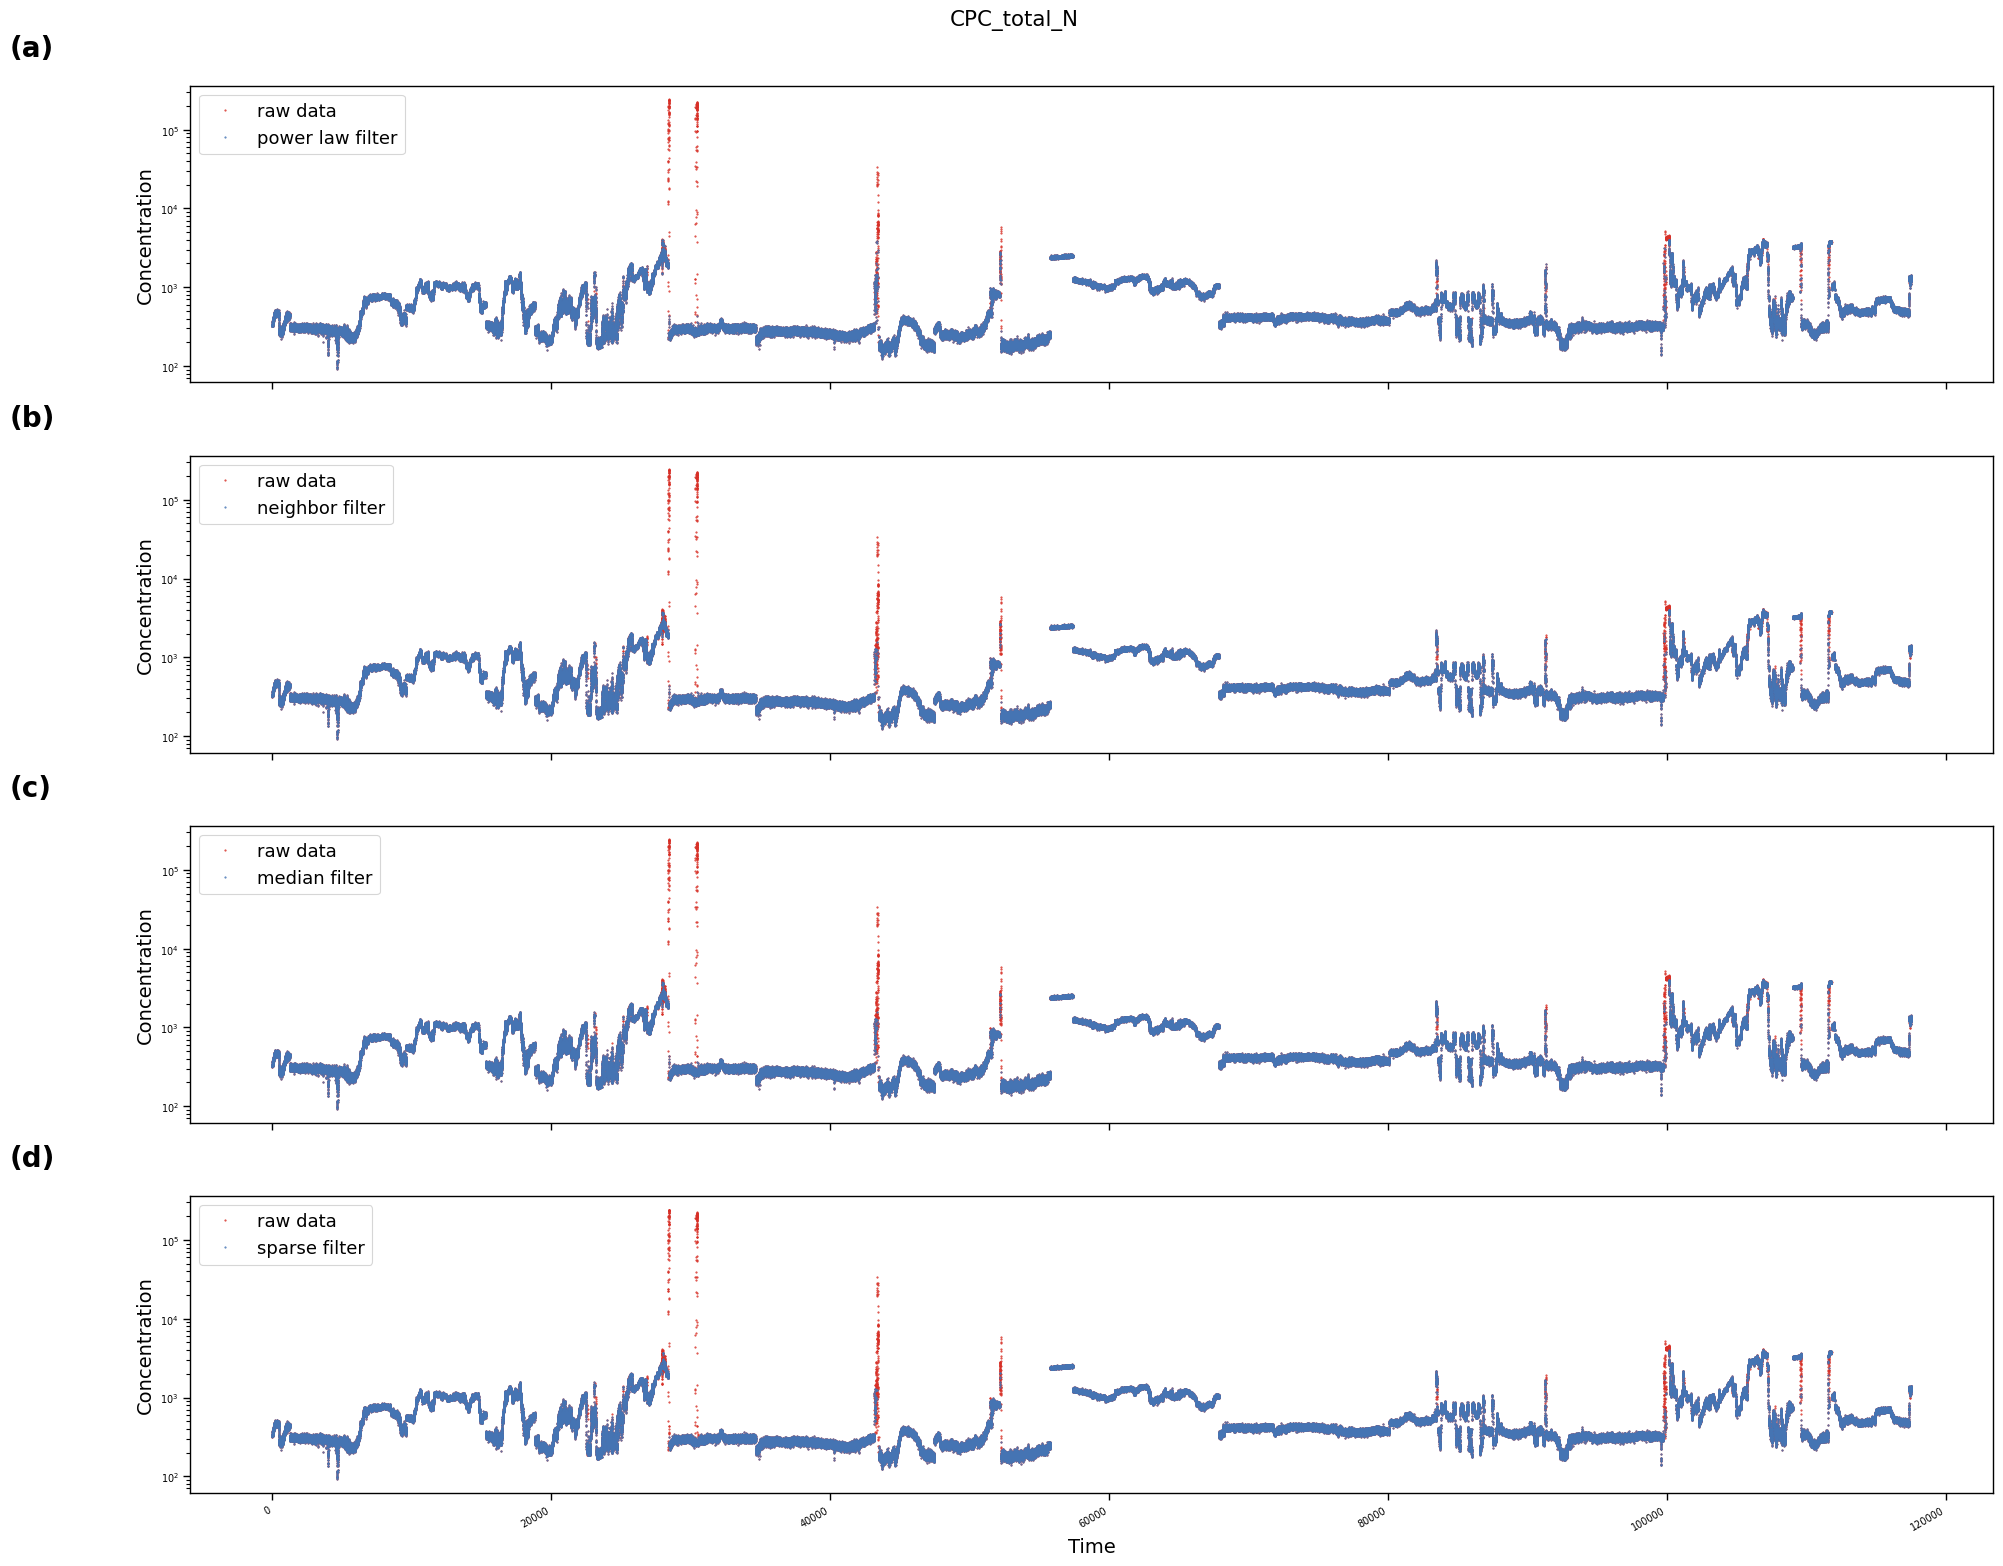

In [13]:
from dataclasses import asdict
from pprint import pprint
from helikite.constants import constants

save_dir = constants.OUTPUTS_FOLDER / "fda"
save_dir.mkdir(exist_ok=True, parents=True)

for col, flag_col in columns_to_flags.items():
    print(f"fda parameters used for {col}:")
    pprint(asdict(best_params[col]), sort_dicts=False)

    fda = FDA(df, col, flag_col, best_params[col])
    flag = fda.detect_pollution()
    FDA.evaluate(df[col], flag, df[flag_col], verbose=True)
    fda.plot_detection(use_time_index=False, markersize=1, save_path=save_dir / f"{flag_col}.png")